In [1]:
import simpy
import numpy as np
import functools
import matplotlib.pyplot as plt
from Stats import Entity, Resource, Source
from pprint import pprint

## Things that changed

1. Queues are now "sampled" at a frequency that is defined by the user.
- Once simulation has completed, call resource.queue_over_time(sample_frequency)
- the default sample frequency is every time increment (1)
- supported sample frequencies = [0.01, 0.1, 1]

More info about how sampling works: 
- during simulation, events that happen at a resource are tracked (someone requested, someone releases, someone starts processing). Queue sizes can only change when one of these events occurs.
- queue is derived from these events, based on sampling window provided.

2. queue over time function now works for continuous time.
- times are stored with whatever resolution is provided at runtime.
- I implemented some rounding under the hood to the nearest 0.01 or 0.1 or 1, based on the sampling frequency that is passed to the queue_over_time function. This might cause some queue events to "overlap" based on the sampling window chosen. 

Example:

Customer 1 accesses resource A at time 0.0543982389

Customer 2 accesses resource A at time 0.1423989876

customer 1 releases resource A at time 0.1827386

When queues are sampled at a resoultion of 1, these events will all look to have occurred at the same time. We will report a queue size of 0.

[{time: 0.0, queue_size: 0}, {time: 1, queue_size: 0} ...]


When queues are sampled at a resoultion of 0.1, both of the resource requested events will be put into the same bucket for time period 0.1 (since they both round to 0.1). The queue will report the following queue sizes over time

[{time: 0.0, queue_size: 0}, 
 {time: 0.1, queue_size: 1}.
 {time: 0.2, queue_size: 0},
 ...
]

When queues are sampled at a resolution of 0.01, there will be more resolution between queue check events.
Customer 1's access of resource A will be rounded to 0.05
Customer 2's access of resource A will be rounded to 0.14
Customer 1's release of resource A (and when customer 2 exits the queue) will be rounded to 0.18

[{time: 0.00, queue_size: 0},
 {time: 0.01, queue_size: 0},
 {time: 0.02, queue_size: 0},
 {time: 0.03, queue_size: 0},
 {time: 0.04, queue_size: 0},
 {time: 0.05, queue_size: 0}.
 {time: 0.06, queue_size: 0}
 {time: 0.07, queue_size: 0}
 {time: 0.08, queue_size: 0}
 {time: 0.09, queue_size: 0}
 {time: 0.10, queue_size: 0}
 {time: 0.11, queue_size: 0}
 {time: 0.12, queue_size: 0}
 {time: 0.13, queue_size: 0}
 {time: 0.14, queue_size: 1}
 {time: 0.15, queue_size: 1}
 {time: 0.16, queue_size: 1}
 {time: 0.17, queue_size: 1}
 {time: 0.18, queue_size: 0}
 {time: 0.19, queue_size: 0}
 {time: 0.20, queue_size: 0}
 {time: 0.21, queue_size: 0}
 ...
]

The frequency at which the queue is sampled does not affect underlying waiting times that entities actually experience in the system.

## Description of problem: 

We are going to model a restaurant.

Customers start by ordering, which is passed to the kitchen.
The Kitchen is described as follows: 
 - 2 cooks
 - 3 things to order:
   - fish -- 15 mins to prepare
   - burger -- 5 mins to prepare
   - salad -- 8 mins to prepare
   
Then must wait for a seat
- people will sit for between 20-30 minutes. 
- Capacity: 4
- Assume all attendees are dining alone (no need to worry about specific party capacity, or matching to tables).


## Step 1: Setting up Resource Classes

First things first, let's define classes to represent our Kitchen and DiningRoom Resources. 
These resources will subclass the `Resource` class from the Stats library provided for this course in `stats.py`. 

The `Resource` class from the Stats library provides some handy helper methods for tracking statistics about Resource usage during simulation, so you don't have to manually instrument this yourself (as long as you subclass Resource).


We must define the following for each resource:
- a name attribute. This should be unique across all resource classes that you define
- a `service_time` function that computes the service time for an entity

Other configuration for resource that is done when you construct an instance:
- capacity -- this is how many entities the resource can process in parallel (e.g. a capacity of 2 on kitchen means 2 chefs).

In [2]:
# Our Kitchen class subclasses resource
class Kitchen(Resource):
    def service_time(self, entity):
        """
        Defines preparation time for each dish
        Since we can pass the entity being processed to next_service_time when we call it, 
        we can react to the requirements of the entity (e.g. fish takes longer to prepare)
        """
        if entity.attributes["food"] == "Fish":
            return 15
        elif entity.attributes["food"] == "Burger":
            return 5
        elif entity.attributes["food"] == "Salad":
            return 8
        else:
            raise Exception("Restaurant does not serve this kind of food")
        

# Our DiningRoom class subclasses Resource
class DiningRoom(Resource):
    def service_time(self, entity):
        """
        random integer of time between 20 and 30 minutes per problem specification
        """
        return np.random.randint(20, 30) # 20 to 30 minute seating per entity



## Step 2: Setting up Entity Class

An entity is conceptually the "things passing through your simulation". In the case of a restaurant, we can think of customers as the entities.  

These entities will travel through the simulation, will request resources, will perform actions that take time, might reneg and jump out of long queues, etc... All of this behavior should be defined in your entity class.

Entities should subclass the `Entity` class from the stats library. The `Entity` class in the Stats library provides a bunch of methods useful for collecting summary statistics about an entity's trip through the system.

An entity class should define the following:
- a `process()` function) -- this defines how entities interact with resources in the system. Resources should be made globally accessible so you can access them in your process function

Entities have the following methods available, which should be used in the body of your `process` function:
- self.request_resource(resource) -- this function has the entity submit a resource request to the resource provided (e.g. self.request_resource(kitchen) will return a request to the kitchen).
- self.start_service_at_resource(resource) -- this function logs when the resource is ready to begin processing the request of the entity. This is needed for statistics gathering.
- self.release_resource(resource, request) -- this function will release the requested resource, freeing it up for another entity to use.

See the definition of the `process` function in the Customer resource below for an example of how to interact with multiple resources during processing.

In [3]:
# entities are in charge of the order in which interactions with resources occur
class Customer(Entity):
    def process(self):
        # interface with kitchen
        request = self.request_resource(kitchen)
        yield request
        
        self.start_service_at_resource(kitchen)
        cook_time = kitchen.service_time(self) # next_service_time is defined in kitchen
        yield self.env.timeout(cook_time)
        
        self.release_resource(kitchen, request)
        
        if np.random.random() <= 0.1:
            print(f"{self.name} sent food back, bump them to the front of the line")
            request = self.request_resource(kitchen, priority_override=0) # second argument is priority
            yield request

            self.start_service_at_resource(kitchen)
            cook_time = kitchen.service_time(self) # next_service_time is defined in kitchen
            yield self.env.timeout(cook_time)

            self.release_resource(kitchen, request)
                
        # interface with dining_room
        request = self.request_resource(dining_room)
        yield request
        
        self.start_service_at_resource(dining_room)
        seat_time = dining_room.service_time(self) # next_service_time is defined in dining_room
        yield self.env.timeout(seat_time)
        
        self.release_resource(dining_room, request)

## Step 3: Setting up Source Class

Now that we have our resource and Entity classes defined, we should implement our Source class. 

Think of the source as the place where the simulation starts. It defines how often entities will arrive to the system (interarrival time) and how those entities are defined. It also keeps track of the number of entities created, and provides helper methods for calculating summary statistics at the end of simulation.

Your source should subclass the `Source` class provided in the stats package.

A source must have:
- an `interarrival_time_generator` -- this is a generator function that will yield the next time that an entity is to be constructed and processed by the simulation. 
- a `build_entity` function -- this defines how entities are constructed when the source needs to build a new one. You can define how entity attributes are selected in this function (more on attributes later)

Additional source configuration:
- number -- this is the number of entities that will be produced during simulation.

In [4]:
# The source is what contains the interarrival time definition, and rules for constructing entities 
# with various attribute sets.
class CustomerSource(Source):
    def interarrival_time_generator(self):
        while True:
            yield np.random.choice([1, 5, 10, 20], p=[0.1,0.3,0.4,0.2])
#             yield np.random.exponential(scale=1.0)
    
    def sample_from_foods(self):
        return np.random.choice(["Fish", "Burger", "Salad"], p=[0.1,0.7,0.2])
    
    def build_entity(self):
        attributes = {
            "food": self.sample_from_foods()
        }
        return Customer(env, attributes)

## Step 4: Configure Classes 

Before beginning simulation, you need to create instances of your source and resource classes. You can pass any parameterizeable configuration to classes at this time (e.g. the capacity of each resource or the number of entities to create from the source).

Also need to construct a simpy.Environment(), and pass this to each class in its constructor.

In [5]:
# Create simulation environment
env = simpy.Environment()

# Configure DiningRoom to have space for 4 diners
dining_room = DiningRoom(env, capacity=2)

# Configure Kitchen to have 2 chefs
kitchen = Kitchen(env, capacity=1)

# Configure source to generate fixed number of entities
source = CustomerSource(env, number=10)

# Aside: if students want to tune various parameters of the simulation, they could configure each component
#        of the simulation here, then loop over the construction of each with different combinations of parameters

## Step 5: Run Simulation 

Running the simulation is pretty simple... just pass your resources as a dictionary to the source.start function, and call env.run()

In [6]:
env.process(source.start())
env.run()

Customer 1 created_at: 5 attributes: {'food': 'Fish', 'priority': 1}
Customer 1 requesting Kitchen: 5
Customer 1 started processing at Kitchen : 5
Customer 1 finished at Kitchen: 20
Customer 1 requesting DiningRoom: 20
Customer 1 started processing at DiningRoom : 20
Customer 2 created_at: 25 attributes: {'food': 'Burger', 'priority': 1}
Customer 2 requesting Kitchen: 25
Customer 2 started processing at Kitchen : 25
Customer 3 created_at: 30 attributes: {'food': 'Salad', 'priority': 1}
Customer 3 requesting Kitchen: 30
Customer 2 finished at Kitchen: 30
Customer 2 requesting DiningRoom: 30
Customer 2 started processing at DiningRoom : 30
Customer 3 started processing at Kitchen : 30
Customer 3 finished at Kitchen: 38
Customer 3 requesting DiningRoom: 38
Customer 1 finished at DiningRoom: 41
Customer 1 disposed: 41
Customer 3 started processing at DiningRoom : 41
Customer 4 created_at: 50 attributes: {'food': 'Burger', 'priority': 1}
Customer 4 requesting Kitchen: 50
Customer 4 started 

## Step 6: Extract Summary Statistics from Source / Resource

Source provides methods that calculate summary statistics about the entities while they were in the system. 

Resource provides methods to see what the queue was like at each resource over time.

See the following code blocks for some plots and calculations made with the summary stats.

In [16]:
system_time = source.get_total_times()
print("total_time:", source.get_total_times())
print("waiting_time:", source.get_waiting_times()) 
print("processing_time:", source.get_processing_times(), "\n")

print("waiting time for kitchen resource", source.get_waiting_times(kitchen))
print("processing time for kitchen resource", source.get_processing_times(kitchen), "\n")

print("waiting time for dining_room resource", source.get_waiting_times(dining_room))
print("processing time for dining_room resource", source.get_processing_times(dining_room), "\n")

queue_over_time_kitchen = kitchen.queue_size_over_time() # sample queue length

print("kitchen queue over time")
pprint(queue_over_time_kitchen)

print("\n", "dining_room queue over time")
queue_over_time_dining_room = dining_room.queue_size_over_time(0.1) # sample queue length
pprint(queue_over_time_dining_room)


total_time: [36, 34, 34, 38, 34, 38, 56, 52, 55, 38]
waiting_time: [0, 0, 3, 4, 4, 5, 0, 20, 21, 7]
processing_time: [36, 34, 31, 34, 30, 33, 56, 32, 34, 31] 

waiting time for kitchen resource [0, 0, 0, 0, 0, 0, 0, 20, 5, 0]
processing time for kitchen resource [15, 5, 8, 5, 5, 8, 30, 5, 5, 5] 

waiting time for dining_room resource [0, 0, 3, 4, 4, 5, 0, 0, 16, 7]
processing time for dining_room resource [21, 29, 23, 29, 25, 25, 26, 27, 29, 26] 

kitchen queue over time
[{'size': 0, 'time': 0},
 {'size': 0, 'time': 1},
 {'size': 0, 'time': 2},
 {'size': 0, 'time': 3},
 {'size': 0, 'time': 4},
 {'size': 0, 'time': 5},
 {'size': 0, 'time': 6},
 {'size': 0, 'time': 7},
 {'size': 0, 'time': 8},
 {'size': 0, 'time': 9},
 {'size': 0, 'time': 10},
 {'size': 0, 'time': 11},
 {'size': 0, 'time': 12},
 {'size': 0, 'time': 13},
 {'size': 0, 'time': 14},
 {'size': 0, 'time': 15},
 {'size': 0, 'time': 16},
 {'size': 0, 'time': 17},
 {'size': 0, 'time': 18},
 {'size': 0, 'time': 19},
 {'size': 0, '

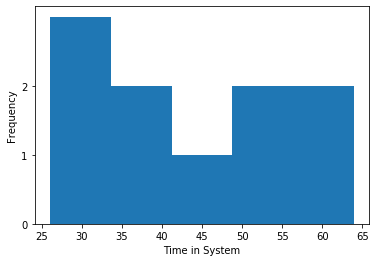

In [8]:
plt.hist(system_time,bins=5)
# you can customize the exact tick marks on an axis
plt.yticks(range(0,3))
plt.ylabel('Frequency');
plt.xlabel('Time in System');

Average number in queue: 0.0
Max in queue: 0


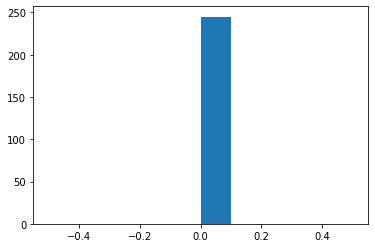

In [26]:
"""
Histogram of queue over time
"""
plt.hist(queue_over_time_kitchen)
print(f"Average number in queue: {np.mean(queue_over_time_kitchen)}")
print(f"Max in queue: {np.max(queue_over_time_kitchen)}")

Average number in queue: 3.1877551020408164
Max in queue: 7


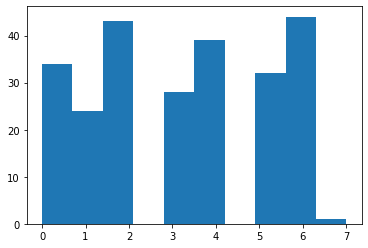

In [27]:
plt.hist(queue_over_time_dining_room)
print(f"Average number in queue: {np.mean(queue_over_time_dining_room)}")
print(f"Max in queue: {np.max(queue_over_time_dining_room)}")

In [12]:
print(f"max system time {np.max(system_time)}")
# 50th percentile, or median
print(f"50th percentile time {np.percentile(system_time,50)}")
print(f"std system time {np.std(system_time)}")

max system time 99
50th percentile time 65.5
std system time 22.737853900489377


## What next? 

Adjust capacities at each resource and see how the summary statistics change.
- how many chefs do you need in the kitchen to ensure 0 wait times with the current interarrival function? 
- What if we expanded our dining room... How big would we need to make the average wait time for a seat to be under 10 minutes? 

Could also adjust interarrival times / resource service times to see how that impacts
- What if we retrained chefs to cook fish 5 seconds faster... would that impact wait times? 
- What if we get a huge rush at night and interarrival time spikes to 1 minute. How bad would wait times get? 
- How to implement reneging customers? 

NameError: name 'apply' is not defined